%config Completer.use_jedi = False

In [5]:
from imageio import imread, imsave
import numpy as np
import cv2
import meshplot
from imageio import imread, imsave
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import cv2
import meshplot as mp

# Part 1

In [352]:
from skimage.color import rgb2gray
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.feature import plot_matches

In [383]:
def sampson_distance(F, x1, x2):
 
    # Compute sampson error for each correspondence.
    Fx1 = np.dot(F, x1)
    Fx2 = np.dot(F, x2)
    denom = Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2
    err = ( np.diag(np.dot(x1.T, np.dot(F,x2))) )**2 / denom 

    # return error per point
    return err

def compute_epipole(F):
    """ Computes the (right) epipole from a
    fundamental matrix F.
    (Use with F.T for left epipole.) """
    
    # Fe_1 = 0, thus need to return null space of F (Fx = 0)
    u,s,vh = np.linalg.svd(F)
    e = vh[-1]
    return e


def plot_epipolar_line(im, F, x, epipole=None, show_epipole=True, start=0):
    """ Plot the epipole and epipolar line F*x=0
        in an image. F is the fundamental matrix 
        and x a point in the other image."""
    
    m,n = im.shape[:2]
    line = np.dot(F,x)
    
    # epipolar line parameter and values
    t = np.linspace(start,n,100)
    lt = np.array([(line[2]+line[0]*tt)/(-line[1]) for tt in t])

    # take only line points inside the image
    ndx = (lt>=0) & (lt<m) 
    plt.plot(t[ndx],lt[ndx],linewidth=2)
    
    if show_epipole:
        if epipole is None:
            epipole = compute_epipole(F)
        plt.plot(epipole[0]/epipole[2],epipole[1]/epipole[2],'r*')

def compute_fundamental(x1,x2):
    """ Computes the fundamental matrix from corresponding points
    (x1,x2 3*n arrays) using the normalized 8 point algorithm.
    each row is constructed as
    [x’*x, x’*y, x’, y’*x, y’*y, y’, x, y, 1] """
    
    n = x1.shape[1]
    A = np.zeros([n,9])
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i], x1[1,i]*x2[0,i], \
                x1[1,i]*x2[1,i], x1[1,i], x2[0,i], x2[1,i], 1 ]
            
    
    u,s,vh=np.linalg.svd(A.T.dot(A))
    f = vh[-1].reshape(3,3)

    u_f,s_f,vh_f = np.linalg.svd(f)

    s_f[-1]=0
    F = u_f.dot(np.diag(s_f)).dot(vh_f)
    
    return F



def compute_fundamental_normalized(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3xn arrays) using the normalized 8 point algorithm. """

    n = x1.shape[1]
    # normalize image coordinates
    mean_x1 = np.mean(x1[:2],axis=1)

    mean_x1_data = np.tile(mean_x1,(n,1)).T

    subs_x1 = x1[:2]-mean_x1_data

    mean_norm_x1 = np.linalg.norm(subs_x1, axis=0, keepdims=False).mean()

    scale_x1 = np.sqrt(2) / mean_norm_x1

    trans_mat_x1 = np.array([[scale_x1,0,-scale_x1*mean_x1[0]],[0,scale_x1,-scale_x1*mean_x1[1]],[0,0,1]])

    x1n = np.dot(trans_mat_x1,x1)

    
    mean_x2 = np.mean(x2[:2],axis=1)

    mean_x2_data = np.tile(mean_x2,(n,1)).T

    subs_x2 = x2[:2]-mean_x2_data

    mean_norm_x2 = np.linalg.norm(subs_x2, axis=0, keepdims=False).mean()

    scale_x2 = np.sqrt(2) / mean_norm_x2

    trans_mat_x2 = np.array([[scale_x2,0,-scale_x2*mean_x2[0]],[0,scale_x2,-scale_x2*mean_x2[1]],[0,0,1]])

    x2n = np.dot(trans_mat_x2,x2)
    # compute F with the normalized coordinates
    F_n = compute_fundamental(x1n, x2n)
    
    F = trans_mat_x1.T.dot(F_n).dot(trans_mat_x2)
    return F



def skew(a):
    """ Skew matrix A such that a x v = Av for any v. """
    return np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])

def make_homog(points):
    return np.vstack((points, np.ones((1, points.shape[1]))))


def triangulate(x1, x2, P1, P2):
    """    
    Two-view triangulation of points in x1,x2 (3xn homog. coordinates). 
    Return: 3xn point cloud
    """
    n = x1.shape[1]
    X = np.zeros([4,n])
    
    for i in range(n):
        mat = np.zeros((6,6))
        mat[:3,:4] = P1
        mat[:3,4] = -x1[:,i]
        mat[3:,:4] = P2
        mat[3:,5] = -x2[:,i]

        u,s,vh = np.linalg.svd(mat.T.dot(mat))
        X[:,i] = vh[-1,:4]
        
    return X



def extract_correspondences(im1, im2, coeff=0.5, num_points=800):
    
    # similar to your panorama implementation, can copy/paste
    im1_g=rgb2gray(im1)
    im2_g=rgb2gray(im2)
    
    orb = ORB(n_keypoints=num_points, fast_threshold=coeff)    
    orb.detect_and_extract(im1_g)
    keypoints1 = orb.keypoints
    descriptors1 = orb.descriptors
   
    orb.detect_and_extract(im2_g)
    keypoints2 = orb.keypoints
    descriptors2 = orb.descriptors
    
    matches_for_plot = match_descriptors(descriptors1,descriptors2,cross_check=True)
    
    pts1 = keypoints1[matches_for_plot[:,0]][:, ::-1]
    pts2 = keypoints2[matches_for_plot[:,1]][:, ::-1]
    kp1= keypoints1
    kp2 = keypoints2

   
    return pts1, pts2, matches_for_plot, kp1, kp2
            

In [217]:
merton1 = imread("data/merton1.jpg")
merton2 = imread("data/merton2.jpg")

## Problem 1

Text(0.5, 1.0, 'basic matching')

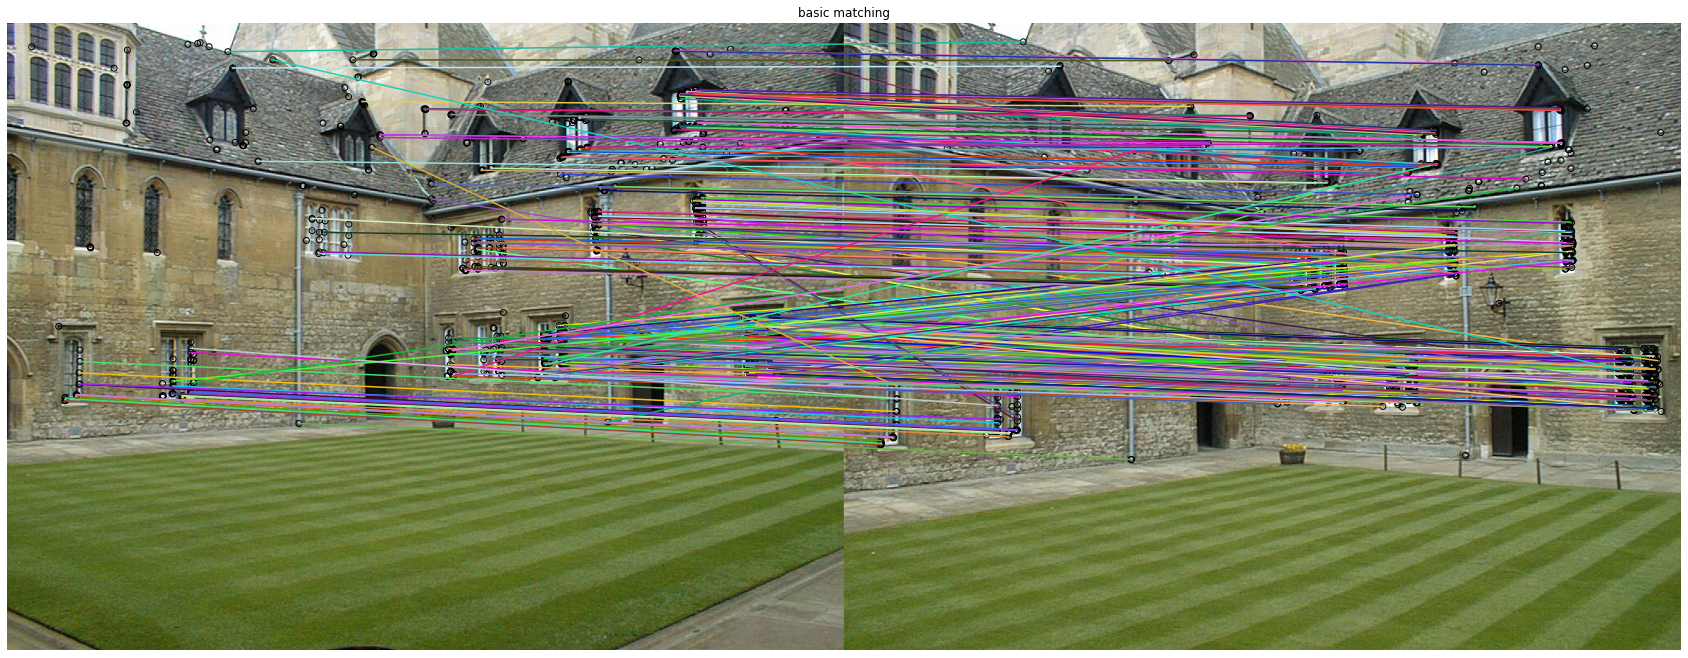

In [353]:
pts1, pts2, matches_for_plot, kp1, kp2 = extract_correspondences(merton1, merton2, coeff=0.3)

# Used skimage for last problem sets instead, here to save some time to not rewrite everything to work with cv2 

# img3 = cv2.drawMatchesKnn(merton1,keypoints1, merton2,
#                           keypoints2, matches_for_plot, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# plt.figure(figsize=(20, 10))
# plt.axis('off')
# plt.imshow(img3)
# plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(30,30))


plot_matches(ax, merton1, merton2, kp1, kp2,
             matches_for_plot)
ax.axis("off")
ax.set_title("basic matching")


In [354]:
# Sampson error

x1 = pts1
x2 = pts2
x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

F = compute_fundamental(x1, x2)

error = sampson_distance(F, make_homog(pts1.T), make_homog(pts2.T))
print(np.median(error))
print("Average Sampson error: {}".format(np.mean(error)))

6230.722369693575
Average Sampson error: 13812.123208409099


In [355]:
# Sampson error

x1 = pts1
x2 = pts2
x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

F = compute_fundamental_normalized(x1, x2)

error = sampson_distance(F, make_homog(pts1.T), make_homog(pts2.T))
print(np.median(error))
print("Average Sampson error: {}".format(np.mean(error)))

544.1151754500219
Average Sampson error: 3015.872154728517


## Answer for Problem 2

A huge improvement is observed when it is normalized. The median error dropped from 6230 to 544 and the average sampson error dropped from 13812 to 3015. The error is quite big, no where near the value provided in the notebook. Possible explanation is that the match points is very noisy. A lot of misalignment is in the data.

## Problem 3

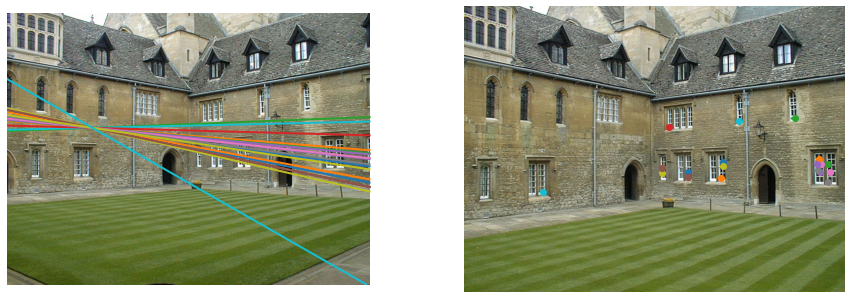

In [356]:
# Epiline plotting

rand_ind = np.random.permutation(pts2.shape[0])

e = compute_epipole(F)

plt.figure(1, figsize=(15,10))
plt.subplot(121)
plt.axis('off')
plt.imshow(merton1)

for i in range(20):
    x = make_homog(pts1.T).T[rand_ind[i],:]
    plot_epipolar_line(merton1, F, x2[:,i], e, False)

plt.subplot(122)
 
plt.axis('off')
plt.imshow(merton2)

for i in range(20):
    plt.plot(x2[0,i],x2[1,i],'o')
    

plt.show()

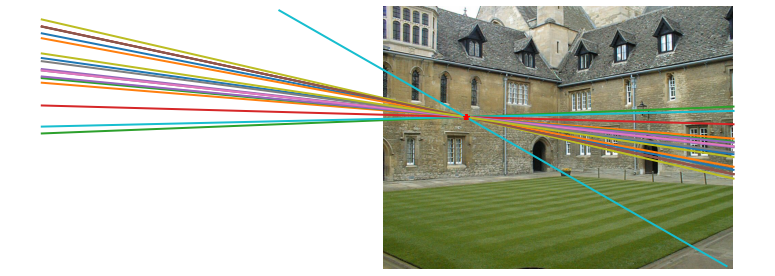

In [358]:
# Epipole plotting

plt.figure(1, figsize=(30,20))

plt.subplot(122)
plt.axis('off')
plt.imshow(merton1)

plt.figure(1, figsize=(15,10))

e = compute_epipole(F.T)

for i in range(20):
    x = make_homog(pts1.T).T[rand_ind[i],:]
    plot_epipolar_line(merton1, F, x2[:,i], e, True, start=-1000)

    
plt.show()

## Problem 4

In [370]:
# Triangulation

P1 = np.loadtxt("data/001.P")
P2 = np.loadtxt("data/002.P")

In [384]:
pts1, pts2, match_for_plot, kp1, kp2 = extract_correspondences(merton1, merton2, coeff=0.5)

x1 = pts1
x2 = pts2

x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

colors = []

for i in range(pts1.shape[0]):
    u, v = pts1[i,:]
    u = int(u)
    v = int(v)
    colors.append(merton1[v, u,:]/255.)
    
colors = np.array(colors)
points_est = triangulate(x1, x2, P1, P2)[:3,:].T

d = mp.subplot(v=points_est, c=colors, s=[1, 2, 0], shading={"point_size": 0.5})

In [397]:
pts1, pts2, match_for_plot, kp1, kp2 = extract_correspondences(merton1, merton2, coeff=0.5, num_points=1600)

x1 = pts1
x2 = pts2

x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

colors = []

for i in range(pts1.shape[0]):
    u, v = pts1[i,:]
    u = int(u)
    v = int(v)
    colors.append(merton1[v, u,:]/255.)
    
colors = np.array(colors)
points_est = triangulate(x1, x2, P1, P2)[:3,:].T

d = mp.subplot(v=points_est, c=colors, s=[1, 2, 0], shading={"point_size": 0.5})

In [400]:
print(kp1.shape)
print(kp2.shape)
print(points_est.shape)

(267, 2)
(347, 2)
(112, 3)


In [388]:
pts1, pts2, match_for_plot, kp1, kp2 = extract_correspondences(merton1, merton2, coeff=0.8)

x1 = pts1
x2 = pts2

x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

colors = []

for i in range(pts1.shape[0]):
    u, v = pts1[i,:]
    u = int(u)
    v = int(v)
    colors.append(merton1[v, u,:]/255.)
    
colors = np.array(colors)
points_est = triangulate(x1, x2, P1, P2)[:3,:].T

d = mp.subplot(v=points_est, c=colors, s=[1, 2, 0], shading={"point_size": 0.5})

In [401]:
pts1, pts2, match_for_plot, kp1, kp2 = extract_correspondences(merton1, merton2, coeff=0.3)

x1 = pts1
x2 = pts2

x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

colors = []

for i in range(pts1.shape[0]):
    u, v = pts1[i,:]
    u = int(u)
    v = int(v)
    colors.append(merton1[v, u,:]/255.)
    
colors = np.array(colors)
points_est = triangulate(x1, x2, P1, P2)[:3,:].T

d = mp.subplot(v=points_est, c=colors, s=[1, 2, 0], shading={"point_size": 0.5})

## Observation on Problem 4

Different coefficient is tested. One big problem is that when the coeffcient is high, there are not enough of points. For example, when coefficient = 0.8, there are only two points available. Even with higher threshold of keypoints value tested, the number of matching points is not changed at all. Did not see the right angle shape illustrated in the problem set instruction. Not sure why it happened. 

# Part 2

## Anwser to Problem 5:

When increasing the value of M, pixels far away from the cluster center tends to not be grouped into the same clusters even when the colors are very similar. All the clustered pixels tends to be in close proximity of the the cluster center thus form a compact blob

In [1]:
import math
from skimage import io, color
import numpy as np
from tqdm import trange

In [2]:
class Cluster:
    
    cluster_index = 1

    def __init__(self, position, color):
        self.pos=np.zeros(2)
        self.lab=np.zeros(3)
        self.pos=np.array(position)
        self.color = np.array(color)
        self.pixel_group = []
        self.idx = self.cluster_index
        Cluster.cluster_index += 1

    def update(self, position, color):
        self.pos=np.array(position)
        self.color = np.array(color)
        

In [13]:
class SLIC:

    def __init__(self, filename, K, M):
        
        self.data = self.load_image(filename)
        self.K = K
        self.M = M

        self.height = self.data.shape[0]
        self.width = self.data.shape[1]
        
        self.S = int(np.sqrt(self.height * self.width / self.K))

        self.cluster_list = []
        self.label_lookup_table = {}
        self.dis = np.full((self.height, self.width), np.inf)
    

    def load_image(self,filename):
        rgb = io.imread(filename)
        lab_arr = color.rgb2lab(rgb)
        return lab_arr
    
    def initiation(self):
        
        for h in np.arange(self.S/2,self.height,self.S):
            for w in np.arange(self.S/2,self.width,self.S):
                h_=int(h)
                w_=int(w)
                self.cluster_list.append(Cluster((h_, w_), self.data[h_][w_]) )
    
    def get_gradient(self, position):
        
        h = position[0]
        w = position[1]
        if h + 1 >= self.height:
            h = self.height - 2
        
        if w + 1 >= self.width:
            w = self.width - 2
        
        gradient = np.linalg.norm(self.data[h + 1][w] - self.data[h - 1][w])**2 + \
                        np.linalg.norm(self.data[h][w + 1] - self.data[h][w - 1])**2

        return gradient

    def minimization(self):
        for cluster in self.cluster_list:
            old_gradient = self.get_gradient(cluster.pos)
            h = cluster.pos[0]
            w = cluster.pos[1]
            for dh in range(-1, 2):
                for dw in range(-1, 2):
                    new_h = h + dh
                    new_w = w + dw
                    new_gradient = self.get_gradient([new_h, new_w])
                    if new_gradient < old_gradient:
                        cluster.update([new_h, new_w], self.data[new_h][new_w])
                        old_gradient = new_gradient
    
    def reassigning(self):
        for cluster in self.cluster_list:
            H = cluster.pos[0]
            W = cluster.pos[1]
            for h in range(H - 2 * self.S, H + 2 * self.S):
                if h < 0 or h >= self.height: continue
                for w in range(W - 2 * self.S, W + 2 * self.S):
                    if w < 0 or w >= self.width: continue
                    
                    lab_vec = self.data[h][w] - cluster.color
                    pos_vec = np.array([h,w]) - cluster.pos
                    d_lab = np.linalg.norm(lab_vec)
                    d_xy = np.linalg.norm(pos_vec)
                    
                    D = d_lab + (self.M/self.S) * d_xy
                    
                    if D < self.dis[h][w]:
                        if (h, w) not in self.label_lookup_table:
                            self.label_lookup_table[(h, w)] = cluster
                            cluster.pixel_group.append((h, w))
                        else:
                            self.label_lookup_table[(h, w)].pixel_group.remove((h, w))
                            self.label_lookup_table[(h, w)] = cluster
                            cluster.pixel_group.append((h, w))
                        self.dis[h][w] = D

    def cluster_updating(self):
        for cluster in self.cluster_list:
            pixle_array = np.array(cluster.pixel_group)
            mean_pos = pixle_array.mean(axis=0).astype(int)

            cluster.update( mean_pos, self.data[tuple(mean_pos)])
    
    def plot_current_image(self):
        image_arr = np.copy(self.data)
        for cluster in self.cluster_list:
            for p in cluster.pixel_group:
                image_arr[p] = cluster.color

            image_arr[tuple(cluster.pos)] = np.array([0,0,0])

        
        rgb_arr = color.lab2rgb(image_arr)
        plt.imshow(rgb_arr)
        plt.show()
        
        
    def label_map(self):
        label_map = np.zeros([self.height,self.width])
        for cluster in self.cluster_list:
            for p in cluster.pixel_group:
                label_map[p] = cluster.idx
            label_map[tuple(cluster.pos)] = cluster.idx
        return label_map
    
    def iterate(self, max_iter=10,cutoff=0.001):
        self.initiation()
        self.minimization()
        old_label_map = self.label_map()
        
        for i in trange(max_iter):
            
            self.reassigning()
            self.cluster_updating()
            
            new_label_map = self.label_map()
            bool_map = new_label_map == old_label_map
            index_unchanged=np.count_nonzero(bool_map)
            
            if index_unchanged/(self.height*self.width) <= cutoff:
                break
            old_label_map=new_label_map
        self.plot_current_image()  

In [8]:
p.data[p.cluster_list[0].pixel_group[0]]

array([ 5.06330541e+00, -3.21466529e-04,  6.09339939e-04])

In [9]:
p.data[0,5]

array([ 5.06330541e+00, -3.21466529e-04,  6.09339939e-04])

In [12]:
p.data[tuple(p.cluster_list[0].pos)]

array([5.15325885, 2.19049934, 0.17559938])

100%|██████████| 10/10 [05:15<00:00, 31.50s/it]


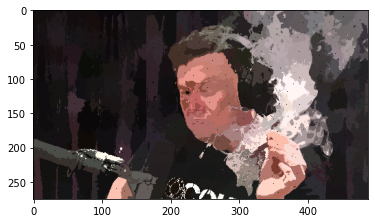

In [14]:
p = SLIC('data/elon.png', K=200, M=5)
p.iterate()

100%|██████████| 20/20 [09:41<00:00, 29.07s/it]


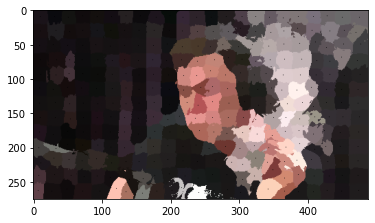

In [339]:
p = SLIC('data/elon.png', K=300, M=40)
p.iterate()

100%|██████████| 10/10 [05:20<00:00, 32.02s/it]


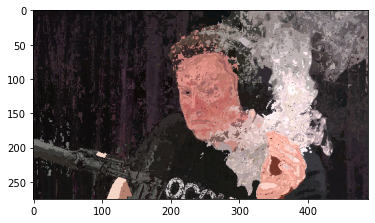

100%|██████████| 10/10 [05:07<00:00, 30.74s/it]


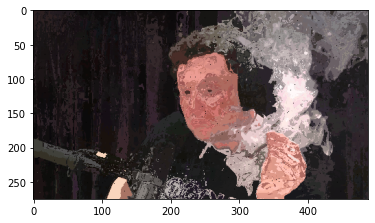

100%|██████████| 10/10 [05:02<00:00, 30.25s/it]


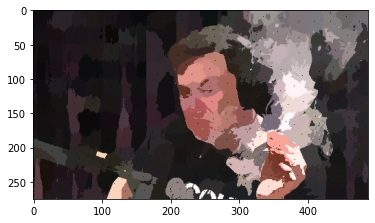

100%|██████████| 10/10 [05:04<00:00, 30.46s/it]


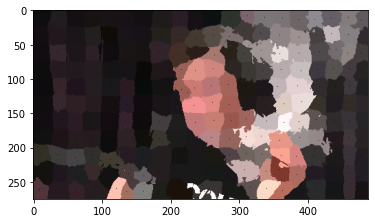

100%|██████████| 10/10 [05:08<00:00, 30.86s/it]


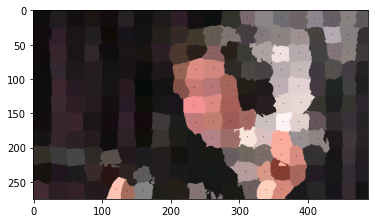

In [348]:
M_list = [0.1, 1, 10, 50, 100]

for m in M_list:
    p = SLIC('data/elon.png', K=200, M=m)
    p.iterate()

  0%|          | 0/10 [01:27<?, ?it/s]


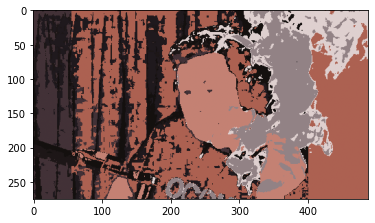

  0%|          | 0/10 [00:49<?, ?it/s]


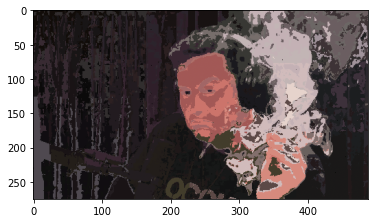

  0%|          | 0/10 [00:42<?, ?it/s]


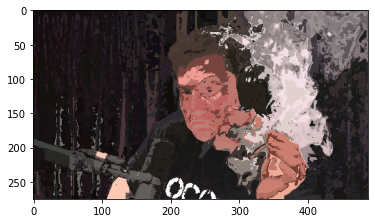

100%|██████████| 10/10 [05:11<00:00, 31.16s/it]


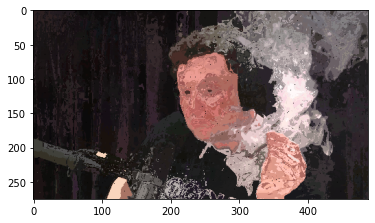

100%|██████████| 10/10 [05:03<00:00, 30.37s/it]


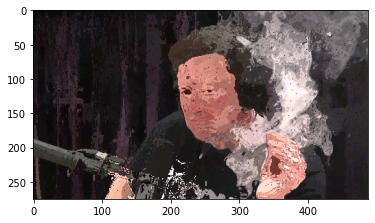

In [350]:
K_list = [10, 50, 100, 200, 400]

for k in K_list:
    p = SLIC('data/elon.png', K=k, M=1)
    p.iterate()

## Anwser to Problem 6

An experiment is conducted with different value of K and M.

When M is small, the location is less dominant thus you can see some of the pictures is better segmented, like the smoke. When M is 0.1, pretty much every smoke is grouped to one clusters. When M is big like 100, the picture is pretty much segment with different square blobs and the smoke is been seperated into different clusters.

When K is small, less color is available, therefore the segmented pictures has a very low resolution, like the cloth would be clustered the same as the curtain behind. When K is larger, more details is captured in the segmentation.

100%|██████████| 10/10 [02:14<00:00, 13.44s/it]


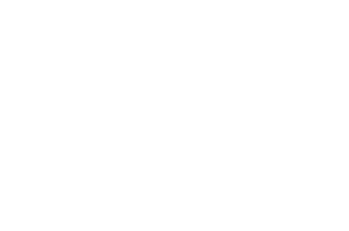

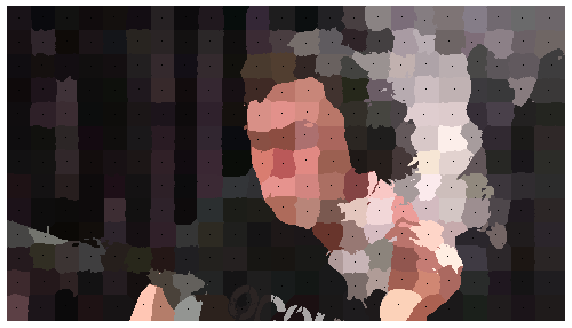

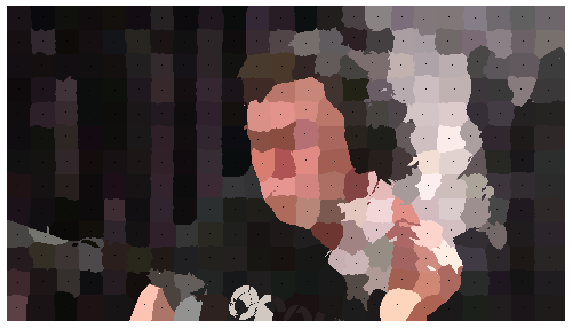

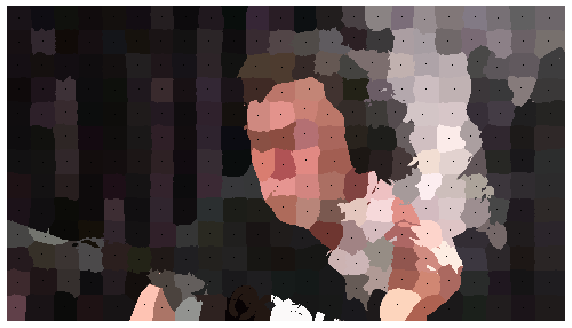

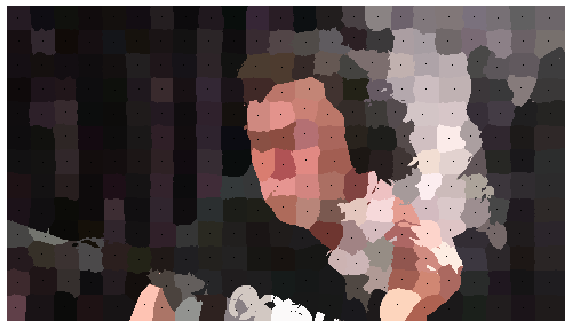

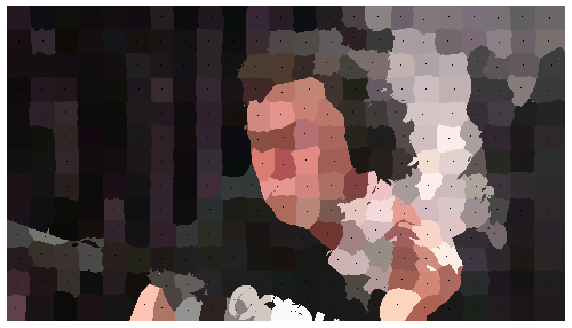

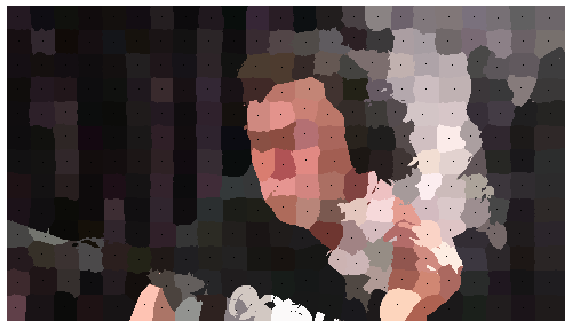

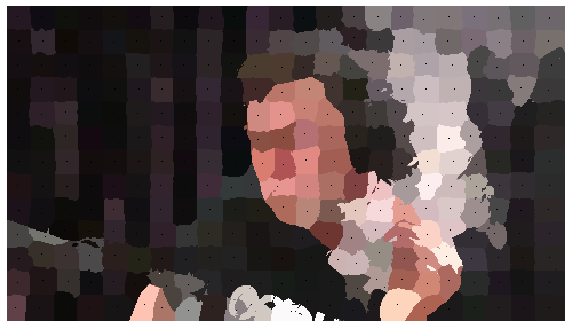

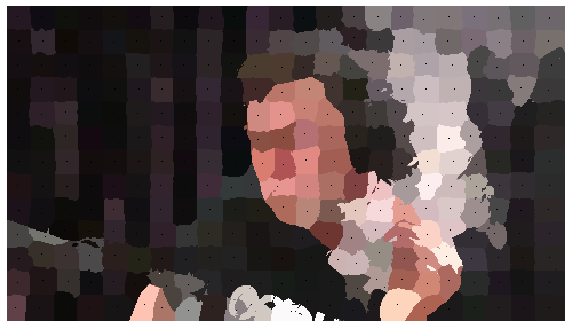

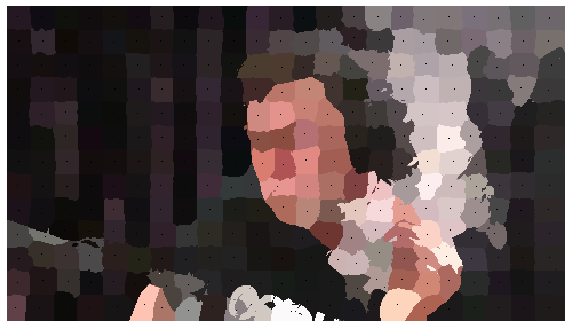

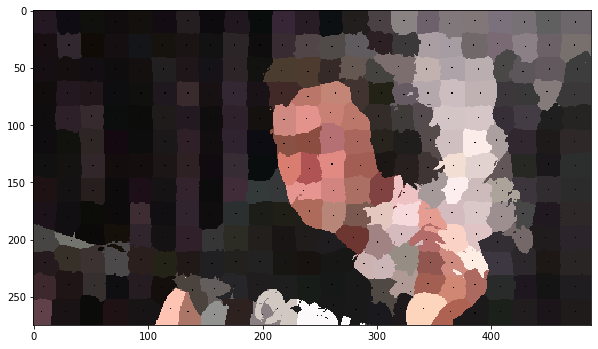

In [10]:
import math
from skimage import io, color
import numpy as np
from tqdm import trange

# note: you can convert to LAB with lab_arr = color.rgb2lab(rgb)

if __name__ == '__main__':
    p = SLIC('data/elon.png', K=300, M=40)
    p.iterate()

